In [137]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

spx = pd.read_csv("data/SPX_long.csv")
spx["Date"] = pd.to_datetime(spx["Date"], format="%Y-%m-%d") 
spx.set_index("Date", inplace=True)

# align to business days; reindex such that missing dates become NaNs
dates = pd.date_range(spx.index[0], spx.index[-1], freq=BDay())
aligned = np.array(spx.Close.reindex(dates))

# calculate 10 day log returns
days = 10
rets = np.log(aligned[days:] / aligned[0:-days]) 
rets = rets[~np.isnan(rets)] 
rets = np.sort(rets)
# zero mean; historical drift not taken to be good predictor
rets = rets - np.mean(rets)      
# normalize returns into units of (maximum-likelihood-estimated) standard deviations
sig = np.std(rets)
rets = rets / sig

def ecdf(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n + 1) / n
    return(x, y)

# calculate an empirical cdf
(x, y) =  ecdf(rets)
# remove the point with probability 1.0
x = x[0:-1]
y = y[0:-1]

xn = norm.ppf(y)

cm = 1.0/2.54

plt.rc('font', size=10)  
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif", # serif
    "font.sans-serif": ["Helvetica"]}) # Palentino

plt.tight_layout()


<Figure size 432x288 with 0 Axes>

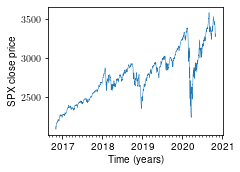

In [138]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig0, (ax0) = plt.subplots(nrows=1, figsize=(8*cm, 6*cm))
fig0.set_facecolor('w')
ax0.plot(spx.index, spx["Close"], linewidth=0.5)
ax0.set_xlabel('Time (years)')
ax0.set_ylabel('SPX close price')

# format the ticks
ax0.xaxis.set_major_locator(years)
ax0.xaxis.set_major_formatter(years_fmt)
ax0.xaxis.set_minor_locator(months)

fig0.savefig('hist_series.pdf', formt='pdf', facecolor=fig0.get_facecolor(), transparent=True, bbox_inches='tight')

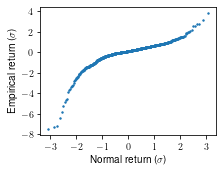

In [139]:
fig1, ax1 = plt.subplots(nrows=1, figsize=(8*cm, 6*cm))
fig1.set_facecolor('w')
ax1.scatter(x=xn, y=x, s=2)
ax1.set_xlabel('Normal return ($\sigma$)')
ax1.set_ylabel('Empirical return ($\sigma$)')
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(2))
fig1.savefig('hist_scatter.pdf', formt='pdf', facecolor=fig1.get_facecolor(), transparent=True, bbox_inches='tight')

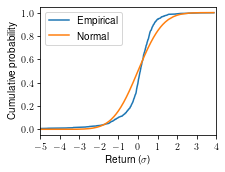

In [140]:
fig2, ax2 = plt.subplots(nrows=1, figsize=(8*cm, 6*cm))
fig2.set_facecolor('w')
ax2.plot(x, y, label="Empirical")
ax2.plot(x, norm.cdf(x), label="Normal")
ax2.set_xlim(-5, 4)
ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(0.2))
ax2.set_xlabel('Return ($\sigma$)')
ax2.set_ylabel('Cumulative probability')
ax2.legend()
fig2.savefig('hist_cdf_linear.pdf', formt='pdf', facecolor=fig2.get_facecolor(), transparent=True, bbox_inches='tight')

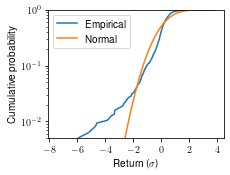

In [141]:
fig3, ax3 = plt.subplots(nrows=1, figsize=(8*cm, 6*cm))
fig3.set_facecolor('w')
ax3.plot(x, y, label="Empirical")
ax3.plot(x, norm.cdf(x), label="Normal")
ax3.set_ylim(0.005, 1.0)
ax3.set_yscale("log")
ax3.xaxis.set_major_locator(MultipleLocator(2))
ax3.set_xlabel('Return ($\sigma$)')
ax3.set_ylabel('Cumulative probability')
ax3.legend()
fig3.savefig('hist_cdf_log.pdf', formt='pdf', facecolor=fig3.get_facecolor(), transparent=True, bbox_inches='tight')

In [32]:
print(norm.ppf(0.01))
from scipy import interpolate
f = interpolate.interp1d(y, x)
print(f(0.01))

-2.3263478740408408
-4.135677012522141


Text(0, 0.5, 'Empirical return')

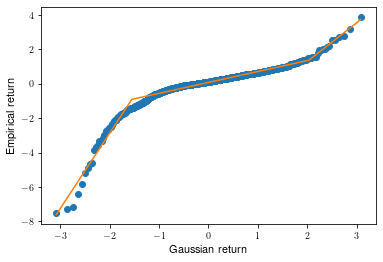

In [142]:
from sklearn.linear_model import LinearRegression
from scipy import optimize
import math
#region = (xn > norm.ppf(0.1)) & (xn < norm.ppf(0.9))
#model = LinearRegression().fit(xn[region].reshape(-1, 1), x[region])

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

def piecewise_linear3(x, x0, y0, rdx0, k0, k1, k2):
    dx0 = rdx0 * rdx0 # use square root of delta as a parameter to keep dx0 > 0
    x1 = x0 + dx0
    y1 = y0 + k1 * dx0 
    return np.piecewise(x, [x < x0, (x >= x0) & (x < x1), x >= x1], [lambda x:k0 * x + y0 - k0 * x0, lambda x:k1 * x + y0 - k1 * x0, lambda x:k2 * x + y1 - k2 * x1])

def piecewise_linear4(x, x0, y0, rdx0, rdx1, k0, k1, k2, k3):
    dx0 = rdx0 * rdx0 # use square root of delta as a parameter to keep dx0 > 0
    dx1 = rdx1 * rdx1
    x1 = x0 + dx0
    y1 = y0 + k1 * dx0 
    x2 = x1 + dx1
    y2 = y1 + k2 * dx1 
    return np.piecewise(x, [x < x0, (x >= x0) & (x < x1), (x >= x1) & (x < x2), x >= x2], [lambda x:k0 * x + y0 - k0 * x0, lambda x:k1 * x + y0 - k1 * x0, lambda x:k2 * x + y1 - k2 * x1, lambda x:k3 * x + y2 - k3 * x2])

def piecewise_linear5(x, y0, k0, k1, k2, k3, k4):
    x0 = -2.04 # -1.28
    x1 = -1.28
    x2 = 1.28
    x3 = 2.04
    y1 = y0 + (x1 - x0) * k1
    y2 = y1 + (x2 - x1) * k2
    y3 = y2 + (x3 - x2) * k3
    return np.piecewise(x, [x < x0, (x >= x0) & (x < x1), (x >= x1) & (x < x2), (x >= x2) & (x < x3)], [lambda x:k0 * x + y0 - k0 * x0, lambda x:k1 * x + y0 - k1 * x0, lambda x:k2 * x + y1 - k2 * x1, lambda x:k3 * x + y2 - k3 * x2, lambda x:k4 * x + y3 - k4 * x3])

def piecewise_linear6(x, y0, k0, k1, k2, k3, k4, k5):
    x0 = -2.04 # -1.28
    x1 = -1.28
    x2 = 0
    x3 = 1.28
    x4 = 2.04
    y1 = y0 + (x1 - x0) * k1
    y2 = y1 + (x2 - x1) * k2
    y3 = y2 + (x3 - x2) * k3
    y4 = y3 + (x4 - x3) * k4
    return np.piecewise(x, [x < x0, (x >= x0) & (x < x1), (x >= x1) & (x < x2), (x >= x2) & (x < x3), (x >= x3) & (x < x4)], [lambda x:k0 * x + y0 - k0 * x0, lambda x:k1 * x + y0 - k1 * x0, lambda x:k2 * x + y1 - k2 * x1, lambda x:k3 * x + y2 - k3 * x2, lambda x:k4 * x + y3 - k4 * x3, lambda x:k5 * x + y4 - k5 * x4])

p, e = optimize.curve_fit(piecewise_linear3, xn, x) #, p0 = p0)
xd = np.linspace(-3, 3, 100)
#plt.scatter(x=xn, y=x)
plt.plot(xn, x, "o")
plt.plot(xn, piecewise_linear3(xn, *p)) # or 5!
plt.xlabel('Gaussian return', fontsize=11)
plt.ylabel('Empirical return', fontsize=11)

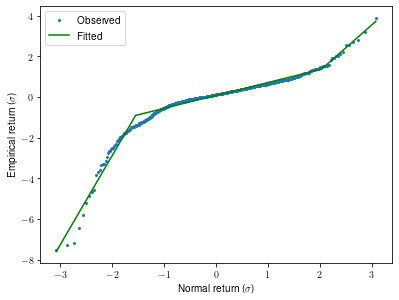

In [144]:

fig4, ax4 = plt.subplots(nrows=1, figsize=(2*8*cm, 2*6*cm))
fig4.set_facecolor('w')
#ax5.scatter(x=xn, y=x, s=2)
ax4.plot(xn, x, "o", markersize = 2, label="Observed")
ax4.plot(xn, piecewise_linear3(xn, *p), label="Fitted", color = "green")

ax4.set_xlabel('Normal return ($\sigma$)')
ax4.set_ylabel('Empirical return ($\sigma$)')
ax4.xaxis.set_major_locator(MultipleLocator(1))
ax4.yaxis.set_major_locator(MultipleLocator(2))
ax4.legend()

fig4.savefig('hist_scatter_fitted.pdf', formt='pdf', facecolor=fig5.get_facecolor(), transparent=True, bbox_inches='tight')

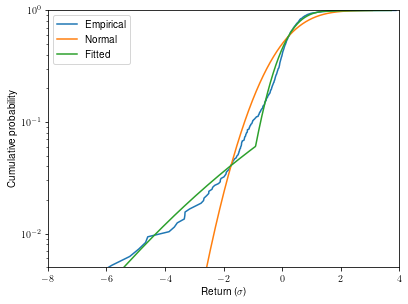

In [145]:
fig5, ax5 = plt.subplots(nrows=1, figsize=(2*8*cm, 2*6*cm))
fig5.set_facecolor('w')
ax5.plot(x, y, label="Empirical")
ax5.plot(xn, norm.cdf(xn), label="Normal")
ax5.plot(piecewise_linear3(xn, *p), norm.cdf(xn), label="Fitted") # plot the fitted empirical return for a given cumulative prob

ax5.set_ylim(0.005, 1.0)
ax5.set_xlim(-8, 4)
ax5.set_yscale("log")
ax5.xaxis.set_major_locator(MultipleLocator(2))
ax5.set_xlabel('Return ($\sigma$)')
ax5.set_ylabel('Cumulative probability')
ax5.legend()
fig5.savefig('hist_cdf_fitted_log.pdf', formt='pdf', facecolor=fig4.get_facecolor(), transparent=True, bbox_inches='tight')

In [146]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

train_x = xn
train_y = x

# fit to piecewise cubmic splines, just to demonstrate that if we want a smooth CDF and PDF we can get one

knots = (-2, -1, 0, 1, 2)

# Cubix spline
transformed_x = dmatrix("bs(train, knots=(-3.0, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3.0), include_intercept=False)", {"train": train_x},return_type='dataframe')

# Generalized linear model fit
fit1 = sm.GLM(train_y, transformed_x).fit()

# Prediction of splines
pred1 = np.array(fit1.predict(dmatrix("bs(valid, knots=(-3.0, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3.0), include_intercept=False)", {"valid": train_x}, return_type='dataframe')))

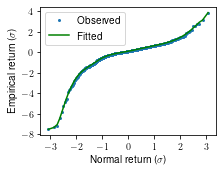

In [152]:
fig6, ax6 = plt.subplots(nrows=1, figsize=(8*cm, 6*cm))
fig6.set_facecolor('w')
#ax5.scatter(x=xn, y=x, s=2)
ax6.plot(xn, x, "o", markersize = 2, label="Observed")
ax6.plot(xn, pred1, label="Fitted", color = "green")

ax6.set_xlabel('Normal return ($\sigma$)')
ax6.set_ylabel('Empirical return ($\sigma$)')
ax6.xaxis.set_major_locator(MultipleLocator(1))
ax6.yaxis.set_major_locator(MultipleLocator(2))
ax6.legend()

fig6.savefig('hist_scatter_spline_fitted.pdf', formt='pdf', facecolor=fig5.get_facecolor(), transparent=True, bbox_inches='tight')

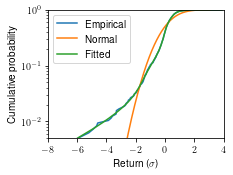

In [151]:
fig7, ax7 = plt.subplots(nrows=1, figsize=(8*cm, 6*cm))
fig4.set_facecolor('w')
ax7.plot(x, y, label="Empirical")
ax7.plot(xn, norm.cdf(xn), label="Normal")
ax7.plot(pred1, norm.cdf(xn), label="Fitted") # plot the fitted empirical return for a given cumulative prob

ax7.set_ylim(0.005, 1.0)
ax7.set_xlim(-8, 4)
ax7.set_yscale("log")

ax7.xaxis.set_major_locator(MultipleLocator(2))
ax7.set_xlabel('Return ($\sigma$)')
ax7.set_ylabel('Cumulative probability')
ax7.legend()
fig7.savefig('hist_cdf_spline_fitted_log.pdf', formt='pdf', facecolor=fig4.get_facecolor(), transparent=True, bbox_inches='tight')

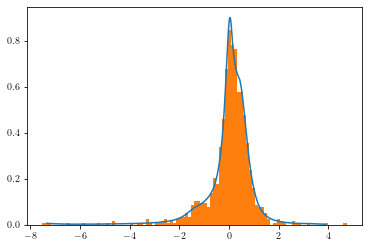

In [136]:
dy = norm.cdf(xn)[1:] - norm.cdf(xn)[0:-1]
dx = pred1[1:] - pred1[0:-1]
fig8, ax8 = plt.subplots(nrows=1, figsize=(8*cm, 6*cm))
fig8.set_facecolor('w')
ax8.plot(pred1[1:], dy/dx)
_ = plt.hist(rets, density = True, bins = 100)

In [107]:
len(dx)

961

In [108]:
dx = pred1[1:] - pred1[0:-1]

In [111]:
pred1[1:3] - pred1[0:2]

0    NaN
1    0.0
2    NaN
dtype: float64

In [112]:
pred1[1:3]

1   -6.970044
2   -6.205384
dtype: float64